In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE

In [56]:
#load in datasets
demographics_df = pd.read_excel("delirium cohort demographics.xlsx", engine='openpyxl') #features of each patient/use to predict
admission_annotation_df = pd.read_csv("data/admission_annotation.csv") #info at admission
admission_gene_df = pd.read_csv("data/admission_norm_gene_exp_df.csv") #gene counts at admission
serial_annotations_df = pd.read_csv("data/serial_samples_annotation.csv") #annotations for subset of patients --> series samples
serial_gene_df = pd.read_csv("data/serial_norm_gene_exp_df.csv") #gene counts for subset of patients --> series samples
gene_symbols_df = pd.read_csv("data/Gene_symbols.csv") #gene IDs


In [57]:
serial_annotations_df.head(2)

,X,Subject,Day,Delirium,Diagnosis,Steroids,Late_del
0,MVIR1.HS101.D0PBMC1.RSQ1,101,0,1,1,0,0
1,MVIR1.HS101.D21PBMC1.RSQ1,101,21,2,1,0,0


In [58]:
gene_symbols_df.head(2)

,Unnamed: 0,gene_ids,gene_symbols
0,ENSG00000000003,ENSG00000000003,TSPAN6
1,ENSG00000000419,ENSG00000000419,DPM1


**Build first model of only using demographic/admission data**


#EDA, preprocess, split, train, evaluate, maybe optimize


In [59]:
demographics_df.shape

(148, 32)

In [60]:
demographics_df.isnull().sum()

Master Record ID                                                 12
Event Name                                                       11
Sequential Organ Failure Assessment (SOFA) Score                145
Age at Admission                                                 17
Sex at Birth                                                     10
Race                                                             11
Hispanic ethnicity                                               11
Length of Hospitalization                                         9
ICU Length of Stay                                                8
SOFA                                                              9
WHO Scale                                                        21
Remdesivir                                                       11
Remdesivir Date Started (HD)                                     67
Remdesiver date ended (HD)                                       67
Convalescent plasma                             

In [61]:
#drop columns
demographics_df = demographics_df.drop(columns=['Sequential Organ Failure Assessment (SOFA) Score', 'Conv Plasma Date Started', 'Conv Plasma HD ended'])
demographics_df = demographics_df[demographics_df['Race'] != 'Delirium']
demographics_df.head(1)

,Master Record ID,Event Name,Age at Admission,Sex at Birth,Race,Hispanic ethnicity,Length of Hospitalization,ICU Length of Stay,SOFA,WHO Scale,...,Hydrocort given,Dementia,Deceased,Cause of death,Was patient on ECMO at any point since the last study visit?,"Non-invasive ventilation (e.g. BiPAP, CPAP)","Nasal cannula, face mask, or HFNC oxygen therapy",Maximum O2 flow via NC or face mask,Invasive ventilation,Delirium at any time during hospitalization
0,1001,Enrollment (Arm 1: Inpatient Visits),34.8,Female,White,0,14,12,10,7.0,...,NaN,No,No,NaN,No,No,No,NaN,Yes,1.0


In [62]:
def process(df, features, target):
    """
    clean data and prepare for predicting
    """
    x = df[features].copy()
    y = df[target].copy()
    
    #clean/set up df filling na values
    x['SOFA'] = pd.to_numeric(x['SOFA'], errors='coerce')
    x['Age at Admission'] = pd.to_numeric(x['Age at Admission'], errors='coerce')

    #fill na
    x['SOFA'] = x['SOFA'].fillna(x['SOFA'].median())
    x['WHO Scale'] = x['WHO Scale'].fillna(x['WHO Scale'].median())
    x['Age at Admission'] = x['Age at Admission'].fillna(x['Age at Admission'].median())
    x['Sex at Birth'] = x['Sex at Birth'].fillna(x['Sex at Birth'].mode()[0])
    x['Race'] = x['Race'].fillna(x['Race'].mode()[0])
    x['Dementia'] = x['Dementia'].fillna(x['Dementia'].mode()[0])

    #target variable, fill with mode for NaNs, for those not 0/1, make 1
    y = y.fillna(y.mode()[0])
    y = y.apply(lambda val: 1 if val!=0 else 0)
    
    #make strings
    x['Sex at Birth'] = x['Sex at Birth'].astype(str)
    x['Race'] = x['Race'].astype(str)
    x['Dementia'] = x['Dementia'].astype(str)
    
    #OHE + standardize features (=proportion)
    numerical_features = ['SOFA', 'WHO Scale', 'Age at Admission']
    categorical_features = ['Sex at Birth', 'Race', 'Dementia']
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(drop='first'), categorical_features)
        ])

    x_processed = preprocessor.fit_transform(x)

    return x_processed, y, preprocessor
    
def model1(df, features, target, test_size=0.2):
    """ 
    Will train a logistic regression model to predict delirium using features

    Parameters:
    - df: input df (demographics_df)
    - features: list of training features of column names
    - target: target predicting column (delirium)

    Output:
    - dictionary of results (accuracy, precision)
    """

    #call process
    X_processed, y, preprocessor = process(df, features, target)

    #split
    X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=test_size)
   
    #train data
    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    #return metrics
    metrics = {
        'Accuracy' : accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'AUC-ROC': roc_auc_score(y_test, y_prob)
    }

    return model, X_test, y_test, metrics

def plot_roc(model, X_test, Y_test, label='Model'):
    """
    plot roc curve given the model
    """
    y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot([0,1], [0,1], color='orange', linestyle='--')
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

In [63]:
feature_col = ['SOFA', 'WHO Scale', 'Sex at Birth', 'Race', 'Dementia', 'Age at Admission']
target_col = 'Delirium at any time during hospitalization'
model, X_test, y_test, metrics = model1(demographics_df, feature_col, target_col)
metrics

{'Accuracy': 0.6666666666666666,
 'Precision': 0.4827586206896552,
 'Recall': 0.6666666666666666,
 'AUC-ROC': 0.8042328042328042}

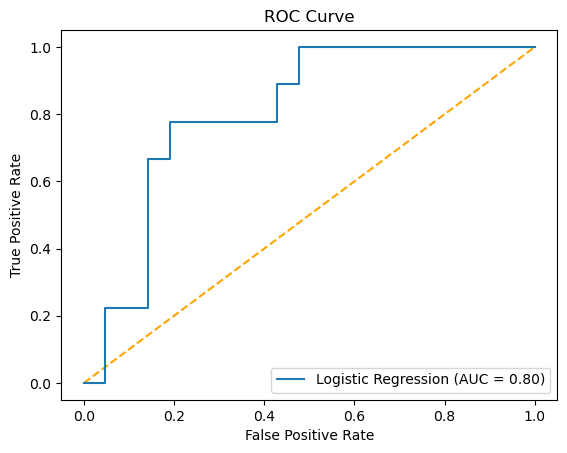

In [64]:
plot_roc(model, X_test, y_test, label='Logistic Regression')

***Results from model 1:*** 

Accuracy is not bad, correctly classifying 87% of instances. However, we have a false positive rate. For all cases where we predicted delirium, only 40% were right. On the other side, only 67% of the time did we correctly identify delirium. Finally, we got a high AUC-ROC score which indicates that we have a 90% chance of correctly distinguishing between a random positive delirium case and non delirium. 

***However, it does vary a lot depending on the iteration. Averaging from 70s-80s (accuracy)***

***Model 2***

Gene trancriptomics to predict delirium

In [65]:
admission_annotation_df.head(1)
#24 out of 112 have delirium

,X,Diagnosis,Steroids
0,MVIR1-HS101-D0PBMC1-RSQ1,1,0


In [66]:
admission_gene_df.head(2)
#ENSG00000274012 = gene

,Unnamed: 0,MVIR1HS101D0PBMC1RSQ1,MVIR1HS107D0PBMC1RSQ1,MVIR1HS109D0PBMC1RSQ1,MVIR1HS10D0PBMC1RSQ4,MVIR1HS111D0PBMC1RSQ1,MVIR1HS127D0PBMC1RSQ1,MVIR1HS130D0PBMC1RSQ1,MVIR1HS131D0PBMC1RSQ1,MVIR1HS143D0PBMC1RSQ1,...,MVIR1HS66D0PBMC1RSQ1,MVIR1HS72D0PBMC1RSQ1,MVIR1HS76D0PBMC1RSQ1,MVIR1HS77D0PBMC1RSQ1,MVIR1HS78D0PBMC1RSQ1,MVIR1HS92D0PBMC1RSQ1,MVIR1HS93D0PBMC1RSQ1,MVIR1HS94D0PBMC1RSQ1,MVIR1HS95D0PBMC1RSQ1,MVIR1HS9D0PBMC1RSQ2
0,ENSG00000274012,18.685163,17.644940,17.109929,8.317684,17.411885,5.610544,18.646658,17.840507,18.166544,...,19.130947,19.487645,17.879548,9.868231,16.945901,16.031702,17.200880,18.105273,17.300451,9.553477
1,ENSG00000244734,17.932175,20.928008,19.025080,19.268316,11.947249,19.173214,5.549448,17.596643,15.211848,...,5.234901,20.983403,15.460700,24.077027,23.252171,23.667655,14.947581,21.801644,17.479552,20.709582


Observations:
    for admission_annotation_df it has identifiers and binary classifiers diagnosis/steriods. For admission_gene_df
    we have a gene expression and then the quantitiy that it shows up for the identifiers. 
    
Plan:
    we first need merge the datasets by pivoting one admission_gene. Then we will standaradize/apply PCA to reduce dimentionality. 
    Then split/train/ and evaluate

In [67]:
#remove hyphens from admission_annotation
new_admission_annotation = admission_annotation_df.copy()
new_admission_annotation['X'] = new_admission_annotation['X'].str.replace('-', '')

In [68]:
#transpose admission_gene_df
X_gene = admission_gene_df.set_index(admission_gene_df.columns[0]).transpose()
X_gene.index.name='X'

merged_gene_df = new_admission_annotation.merge(X_gene, on ='X', how='inner')
merged_gene_df

,X,Diagnosis,Steroids,ENSG00000274012,ENSG00000244734,ENSG00000188536,ENSG00000206172,ENSG00000202538,ENSG00000158578,ENSG00000200312,...,ENSG00000121644,ENSG00000166619,ENSG00000265241,ENSG00000088448,ENSG00000198663,ENSG00000177479,ENSG00000103275,ENSG00000182973,ENSG00000078140,ENSG00000154144
0,MVIR1HS101D0PBMC1RSQ1,1,0,18.685163,17.932175,16.035154,13.760147,13.842371,12.345106,13.822952,...,9.191311,10.445101,10.928632,11.158368,11.004793,11.349125,11.646860,9.814219,10.621316,10.634878
1,MVIR1HS107D0PBMC1RSQ1,1,0,17.644940,20.928008,18.412823,16.476078,13.123230,14.270686,12.871229,...,9.044268,10.414378,10.563948,11.136085,10.780020,11.238639,11.471842,9.635421,10.415488,10.494257
2,MVIR1HS109D0PBMC1RSQ1,0,0,17.109929,19.025080,15.875361,15.005524,12.992272,13.143869,12.205144,...,9.196305,10.604264,10.730673,11.018725,10.744570,11.125231,11.680329,9.608055,10.407175,10.517881
3,MVIR1HS10D0PBMC1RSQ4,0,0,8.317684,19.268316,16.648941,15.397664,6.048804,11.103061,5.234901,...,9.263293,10.585767,10.500445,11.315396,10.983885,10.810117,11.348690,9.811048,10.761488,11.001319
4,MVIR1HS111D0PBMC1RSQ1,0,0,17.411885,11.947249,9.720248,7.927620,13.171352,6.463404,12.816903,...,9.258195,10.439392,10.583444,11.153840,10.584126,10.944706,11.592284,9.722730,10.431077,10.453642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,MVIR1HS92D0PBMC1RSQ1,0,0,16.031702,23.667655,21.494664,19.745895,13.943842,18.547955,8.985676,...,8.858559,10.473358,10.814743,10.888499,10.842227,11.082198,11.525985,9.495530,10.570695,10.619172
108,MVIR1HS93D0PBMC1RSQ1,0,0,17.200880,14.947581,12.516802,9.810907,12.558799,8.710022,12.403568,...,9.167019,10.620788,10.396085,11.258979,10.850142,11.096517,11.574411,9.628576,10.401570,10.595889
109,MVIR1HS94D0PBMC1RSQ1,1,0,18.105273,21.801644,19.656004,17.670340,13.460038,16.253286,13.400188,...,9.215409,10.226281,10.482270,11.030817,10.621026,11.107376,11.244633,9.596301,10.426907,10.394739
110,MVIR1HS95D0PBMC1RSQ1,0,0,17.300451,17.479552,15.274942,12.650929,12.999527,9.997194,12.702459,...,9.111433,10.648725,10.631574,11.104984,10.724972,10.976578,11.675193,9.483663,10.396072,10.698376


In [69]:
def apply_pca(df, n_components=10):
    """
    apply pca to gene expression columns in df

    param: df, n_components = number of principal components to keep

    returns: df with reduced dimension
    
    """
    #gene expressions
    gene_data = gene_data = df.filter(regex="^ENSG")

    #stanrdize gene data
    scaler = StandardScaler()
    gene_data_scaled = scaler.fit_transform(gene_data)
    
    #apply pca
    pca = PCA(n_components = n_components)
    gene_data_pca = pca.fit_transform(gene_data_scaled)
    
    #convert PCA result to df
    gene_data_pca_df = pd.DataFrame(gene_data_pca, columns=[f"PC{i+1}" for i in range(n_components)])
    
    # concatenate the pca components back with the rest of the data
    non_gene_data = df.drop(columns=gene_data.columns)
    final_df = pd.concat([non_gene_data, gene_data_pca_df], axis=1)

    return final_df

def model2_logistic(df, target, test_size=0.2):
    """
    train logistic model using pca-transformed data

    param: df, target col, test_size

    returns: dict with model evaluation metrics

    """
    X = df.select_dtypes(include=[float, int]).drop(columns=[target_col])
    y = df[target_col]

    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    # train logistic regression model
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    
    # make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # calculate metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_prob)
    }
    
    return model, X_test, y_test, metrics

def model2_randomforest(df, target, test_size=0.2, n_estimators=100, max_depth=None):
    X = df.select_dtypes(include=[float, int]).drop(columns=[target])
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # Initialize model with class_weight
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight='balanced')
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=1),
        'Recall': recall_score(y_test, y_pred, zero_division=1),
        'AUC-ROC': roc_auc_score(y_test, y_prob)
    }
    return model, X_test, X_train, y_test, metrics

def feature_selection_df(df, target, k=100):
    """
    select top k genes or features using ANOVA
    """
    gene_df = df.filter(regex="^ENSG")

    selector = SelectKBest(f_classif, k=k)
    selector.fit(gene_df, df[target])

    selected_genes = gene_df.columns[selector.get_support()]
    selected_genes_df = df[selected_genes]

    non_gene_df = df[['Diagnosis', 'Steroids']]

    return_df = pd.concat([non_gene_df, selected_genes_df], axis=1)
    return return_df

def model2_regularized(df, target, test_size=0.2):
    """
    Use Lasso logistic regression model
    """
    
    X = df.drop(columns=[target])
    y = df[target]
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=42)
    
    # Train logistic regression with L1 regularization (Lasso)
    model = LogisticRegression(penalty='l1', solver='saga', max_iter=1000, C=0.1)  # C controls regularization strength
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Evaluate model
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'AUC-ROC': roc_auc_score(y_test, y_prob)
    }
    
    return model, X_test, y_test, metrics


def model2_gradient(df, target, test_size=0.2):
    """
    Use gradient boosting to train my model
    
    param: df (selected_features), target (prediction col)

    returns: dictionary with metrics
    """
    
    X = df.drop(columns=[target])  # Selected features only
    y = df[target]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    # Initialize and train the Gradient Boosting model
    model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3)
    model.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_prob)
    }
    
    return model, X_test, X_train, y_test, metrics

def plot_shap(model, X_train, plot_size=(2,2)):
    """
    plot shap summary to show feature importance
    """
    # Create SHAP explainer and compute SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)

    plt.figure(figsize=plot_size)
    
    # Check if shap_values is a list (e.g., for tree-based classifiers with classes)
    if isinstance(shap_values, list):
        shap.summary_plot(shap_values[1], X_train)  # Choose class 1 for binary classification
    else:
        shap.summary_plot(shap_values, X_train)


{'Accuracy': 0.7391304347826086,
 'Precision': 0.4,
 'Recall': 0.4,
 'AUC-ROC': 0.7000000000000001}

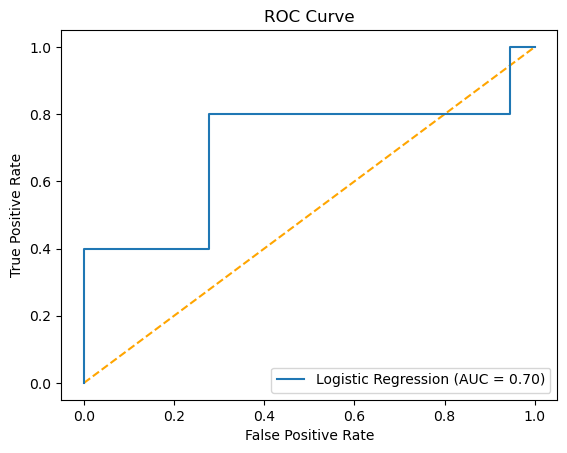

In [70]:
#try pca model
pca_df = apply_pca(merged_gene_df, n_components=50)

target_col = 'Diagnosis'
logistic_model, X_test, y_test, pca_metrics = model2_logistic(pca_df, target_col)
plot_roc(logistic_model, X_test, y_test, label='Logistic Regression')
pca_metrics

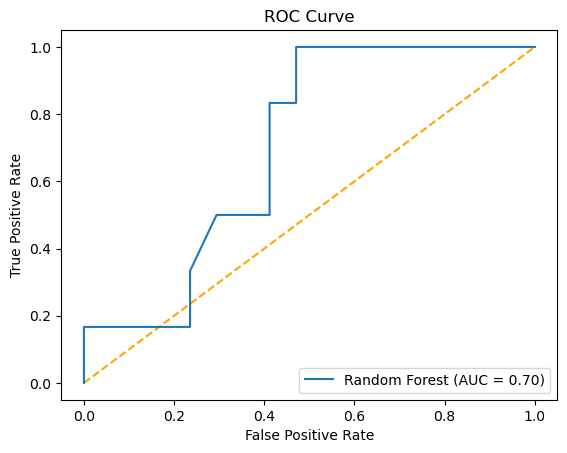

<Figure size 200x200 with 0 Axes>

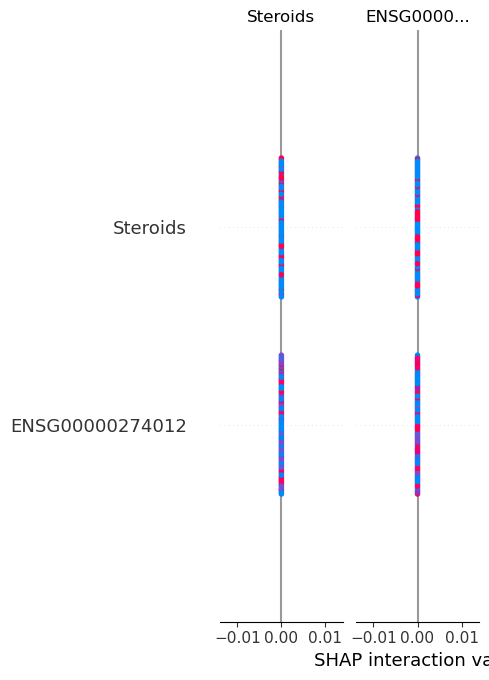

(None,
 {'Accuracy': 0.7391304347826086,
  'Precision': 0.5,
  'Recall': 0.16666666666666666,
  'AUC-ROC': 0.7009803921568627},
 None)

In [71]:
#try random forest model
model_rf, X_test, X_train, y_test, rf_metrics = model2_randomforest(merged_gene_df, target_col)
rf_metrics
plot_roc(model_rf, X_test, y_test, label='Random Forest'), rf_metrics, plot_shap(model_rf, X_train)


{'Accuracy': 0.8260869565217391,
 'Precision': 0.0,
 'Recall': 0.0,
 'AUC-ROC': 0.631578947368421}

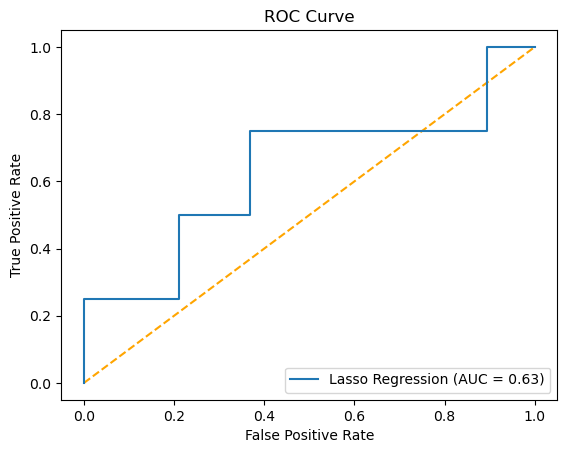

In [72]:
#try lasso model
selected_features = feature_selection_df(merged_gene_df, target_col, k=200)
model_lasso, X_test, y_test, lasso_metrics = model2_regularized(selected_features, target_col)
plot_roc(model_lasso, X_test, y_test, label='Lasso Regression')
lasso_metrics


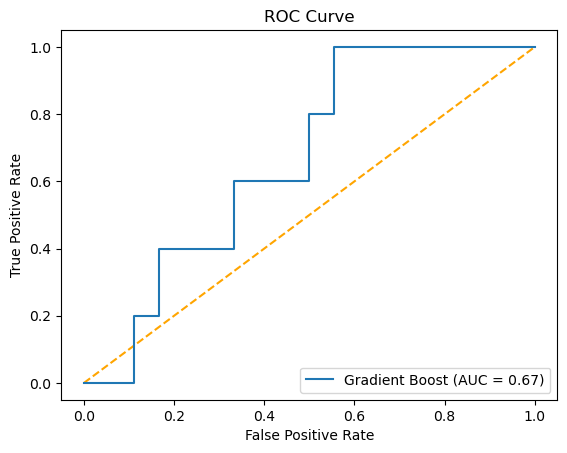

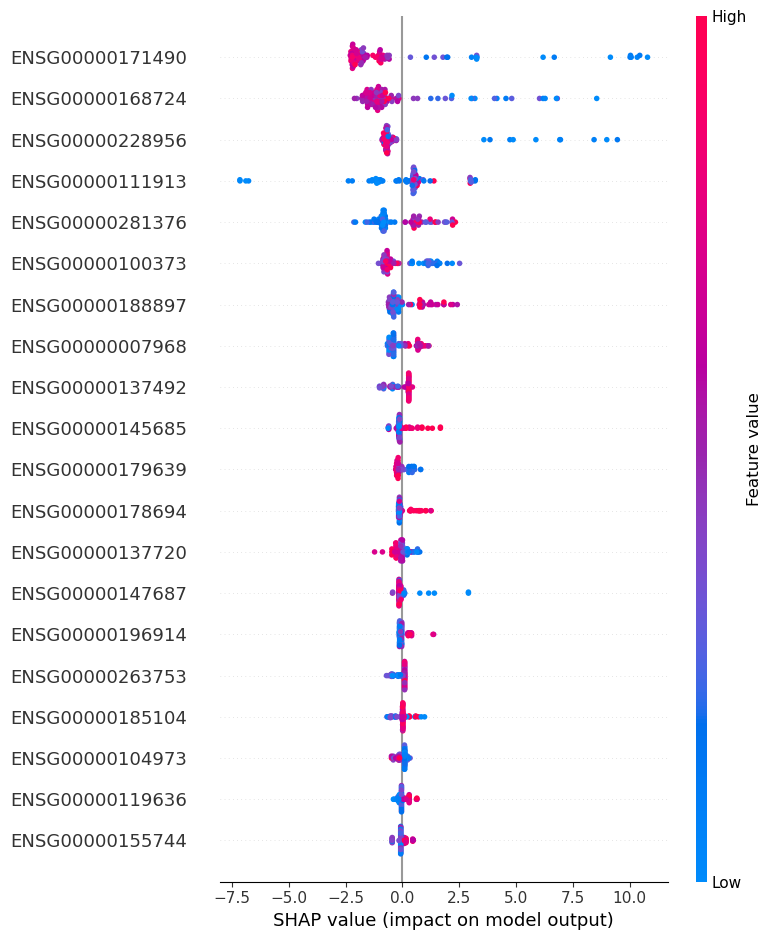

({'Accuracy': 0.6956521739130435,
  'Precision': 0.25,
  'Recall': 0.2,
  'AUC-ROC': 0.6666666666666667},
 None,
 None)

In [73]:
#try gradient boost
selected_features = feature_selection_df(merged_gene_df, target_col, k=70)
gb_model, X_test, X_train, y_test, gb_metrics = model2_gradient(selected_features,target_col)
gb_metrics, plot_roc(gb_model, X_test, y_test, label='Gradient Boost'), plot_shap(gb_model, X_train)


In [74]:
admission_gene_df = pd.read_csv("data/admission_norm_gene_exp_df.csv") #gene counts at admission
serial_annotations_df = pd.read_csv("data/serial_samples_annotation.csv") #annotations for subset of patients --> series samples
serial_gene_df = pd.read_csv("data/serial_norm_gene_exp_df.csv") #gene counts for subset of patients --> series samples
gene_symbols_df = pd.read_csv("data/Gene_symbols.csv") #gene IDs

***Model 4: serial norm gene expression/longitudinal***


In [84]:
serial_gene_df.head(-1)

,Unnamed: 0,MVIR1.HS101.D0PBMC1.RSQ1,MVIR1.HS101.D21PBMC1.RSQ1,MVIR1.HS101.D4PBMC1.RSQ1,MVIR1.HS101.D7PBMC1.RSQ1,MVIR1.HS107.D0PBMC1.RSQ1,MVIR1.HS107.D14PBMC1.RSQ1,MVIR1.HS107.D21PBMC1.RSQ1,MVIR1.HS107.D28PBMC1.RSQ1,MVIR1.HS107.D4PBMC1.RSQ1,...,MVIR1.HS78.D7PBMC1.RSQ1,MVIR1.HS94.D0PBMC1.RSQ1,MVIR1.HS94.D14PBMC1.RSQ1,MVIR1.HS94.D21PBMC1.RSQ1,MVIR1.HS94.D28PBMC1.RSQ1,MVIR1.HS94.D4PBMC1.RSQ1,MVIR1.HS94.D7PBMC1.RSQ1,MVIR1.HS95.D0PBMC1.RSQ1,MVIR1.HS95.D4PBMC1.RSQ1,MVIR1.HS95.D7PBMC1.RSQ1
0,DPM1,9.383461,10.310383,10.375083,10.371731,9.310316,9.722012,9.738628,9.721323,9.265785,...,9.632137,9.060587,9.591066,9.598311,9.330273,9.642479,9.237258,9.545304,10.191289,10.122949
1,SCYL3,8.366948,7.956377,7.873112,7.121040,8.173659,7.989534,7.991571,7.978328,7.249722,...,7.835454,8.448783,7.956003,8.112171,7.451768,8.018165,8.081720,8.173131,8.146510,8.068521
2,C1orf112,7.891559,6.741496,7.468121,7.248001,7.445675,7.230942,7.540064,7.383477,6.734540,...,7.093991,7.681781,7.217095,7.189786,6.822362,7.412978,7.098533,7.229096,7.283772,6.917523
3,FGR,12.660471,14.552471,13.870511,13.819690,13.415327,14.077551,14.020591,14.039479,13.889838,...,14.221040,13.131565,14.167174,13.790594,13.384089,13.917705,13.805022,13.566704,13.354536,13.814906
4,CFH,7.387890,6.922546,7.497476,7.519009,7.035895,6.886334,6.813783,6.836159,6.535773,...,6.077664,7.418390,7.057395,6.988438,7.720554,7.297824,7.301619,6.412091,7.093077,7.285306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13101,TRBV6-3,5.091633,5.535193,5.673409,5.703401,6.903513,7.602768,7.725547,7.660036,7.167586,...,5.397684,6.142989,6.569868,6.786713,7.364577,6.340464,7.191018,6.858488,7.658860,7.698143
13102,C13orf46,10.232327,5.367325,5.415525,5.469294,8.910014,6.784937,6.719877,6.745797,8.548191,...,6.735925,9.232586,6.957204,6.425234,7.364577,6.252479,6.876925,8.576010,5.843781,5.543381
13103,CNTNAP3C,4.495889,6.153656,4.109131,4.450575,5.652481,5.127775,5.454483,5.298527,5.180849,...,5.217448,4.546566,4.829091,4.717910,4.109131,4.843053,5.422718,5.043044,5.157017,5.207117
13104,MIR1244-2,7.485804,7.918214,8.144562,8.476149,7.386398,7.356107,7.229039,7.291898,7.281277,...,7.150234,7.102916,7.150869,7.409275,7.493427,6.964806,7.098533,7.965150,8.069346,8.258430


In [75]:
serial_annotations_df.head(10)

,X,Subject,Day,Delirium,Diagnosis,Steroids,Late_del
0,MVIR1.HS101.D0PBMC1.RSQ1,101,0,1,1,0,0
1,MVIR1.HS101.D21PBMC1.RSQ1,101,21,2,1,0,0
2,MVIR1.HS101.D4PBMC1.RSQ1,101,4,0,1,0,0
3,MVIR1.HS101.D7PBMC1.RSQ1,101,7,0,1,0,0
4,MVIR1.HS107.D0PBMC1.RSQ1,107,7,0,1,0,1
5,MVIR1.HS107.D14PBMC1.RSQ1,107,0,0,1,0,1
6,MVIR1.HS107.D21PBMC1.RSQ1,107,14,0,1,0,1
7,MVIR1.HS107.D28PBMC1.RSQ1,107,21,0,1,0,1
8,MVIR1.HS107.D4PBMC1.RSQ1,107,28,0,1,0,1
9,MVIR1.HS107.D7PBMC1.RSQ1,107,4,0,1,0,1


In [76]:
gene_symbols_df.head(1)

,Unnamed: 0,gene_ids,gene_symbols
0,ENSG00000000003,ENSG00000000003,TSPAN6


In [187]:
def clean_serial_gene(df):
    # Extract Day 4 and Day 7 columns
    df_copy = df.copy()
    day_4_columns = [col for col in df_copy.columns if 'D4PBMC1' in col]
    day_7_columns = [col for col in df_copy.columns if 'D7PBMC1' in col]

    # Select gene identifier and Day 4/Day 7 columns
    relevant_columns = ['Unnamed: 0'] + day_4_columns + day_7_columns
    cleaned_df = df_copy[relevant_columns]

    # Rename columns for clarity
    renamed_columns = ['gene'] + \
                      [col.replace('D4PBMC1', 'D4') for col in day_4_columns] + \
                      [col.replace('D7PBMC1', 'D7') for col in day_7_columns]
    
    cleaned_df.columns = renamed_columns
    cleaned_df = cleaned_df.drop_duplicates().dropna()
    return cleaned_df

def compute_change(cleaned_df):
    #extract day 4/7
    day_4_columns = [col for col in cleaned_df.columns if 'D4' in col]
    day_7_columns = [col for col in cleaned_df.columns if 'D7' in col]
    
    # Compute changes
    change_df = cleaned_df[['gene']].copy()  # Start with the gene column
    for d4_col, d7_col in zip(day_4_columns, day_7_columns):
        subject_id = d4_col.split('.')[1]  # Extract subject ID
        change_df[f'{subject_id}_change'] = cleaned_df[d7_col] - cleaned_df[d4_col]
    return change_df

def reshape_changed(serial_changed):
    # Reshape to long format
    reshape_changed_df = pd.melt(
        serial_changed,
        id_vars=['gene'],  # Keep the gene column fixed
        var_name='subject',  # Column name for reshaped subject IDs
        value_name='change_expression'  # Column name for expression changes
    )

    # Extract numeric part of subject IDs (e.g., 101 from HS101_change)
    reshape_changed_df['subject'] = reshape_changed_df['subject'].str.extract(r'HS(\d+)_change')[0].astype(int)

    # Return the reshaped DataFrame
    return reshape_changed_df

def merge_with_annotations(reshaped_df, annotations_df):
    # Ensure 'Subject' is an integer
    annotations_df['Subject'] = annotations_df['Subject'].astype(int)

    # Filter for Day 4 and Day 7 only
    filtered_annotations = annotations_df[annotations_df['Day'].isin([4, 7])]

    # Merge reshaped_df with filtered_annotations
    merged_df = reshaped_df.merge(
        filtered_annotations,
        left_on='subject',
        right_on='Subject',  # Match with 'Subject' in annotations_df
        how='inner'
    )

    # Create a pivot table for features (X)
    features = merged_df.pivot_table(
        index='subject', columns='gene', values='change_expression'
    ).reset_index()

    # Extract the target variable (Diagnosis) from annotations_df
    target = annotations_df[['Subject', 'Diagnosis']].drop_duplicates(subset='Subject')
    
    # Merge features and target
    return_df = features.merge(target, left_on='subject', right_on='Subject', how='inner')
    return_df = return_df.drop(columns='Subject')  # Drop duplicate subject column

    return return_df

In [188]:
serial_clean = clean_serial_gene(serial_gene_df)
serial_changed = compute_change(serial_clean)
serial_reshaped = reshape_changed(serial_changed)
serial_merged = merge_with_annotations(serial_reshaped, serial_annotations_df)
serial_merged.head(1)

,subject,A1BG-AS1,A2M,A2M-AS1,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,Diagnosis
0,1,-0.331495,0.961177,0.667373,0.458591,0.595896,0.220524,0.212959,-0.137955,0.065506,...,0.488616,0.79757,0.886987,0.875327,0.102816,0.027303,-0.606386,-0.12647,0.439448,1


In [189]:
def model4(data, top_n_features=20, apply_smote=True):
    # Separate features and target
    X = data.drop(columns=['subject', 'Diagnosis'])
    y = data['Diagnosis']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Feature reduction
    print("Reducing features based on importance...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    model_temp = LogisticRegression(
        penalty='l1',
        solver='liblinear',
        class_weight='balanced',
        random_state=42
    )
    model_temp.fit(X_train_scaled, y_train)
    feature_importances = pd.DataFrame({
        'gene': X.columns,
        'coefficient': model_temp.coef_[0]
    }).sort_values(by='coefficient', ascending=False)
    top_features = feature_importances.head(top_n_features)['gene'].tolist()
    X_train = X_train[top_features]
    X_test = X_test[top_features]

    # SMOTE for class balancing
    if apply_smote:
        print("Applying SMOTE to balance classes...")
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Logistic Regression with L1 regularization
    model = LogisticRegression(
        penalty='l1',
        solver='liblinear',
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_train, y_train)

    # Predictions and evaluation
    y_pred = model.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    print(f"\nCross-validated F1-scores: {scores.mean()} (+/- {scores.std()})")

    # Top features
    print("\nTop Genes by Coefficient:")
    print(feature_importances.head(top_n_features))

    return model, feature_importances

In [200]:
model_4_rf, genes = model4(
    data=serial_merged,
    apply_smote=True
)
model_4_rf

Reducing features based on importance...
Applying SMOTE to balance classes...

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.60      0.75      0.67         4

    accuracy                           0.73        11
   macro avg       0.72      0.73      0.72        11
weighted avg       0.75      0.73      0.73        11


Confusion Matrix:
[[5 2]
 [1 3]]

Cross-validated F1-scores: 0.8916239316239316 (+/- 0.09682278233855594)

Top Genes by Coefficient:
             gene  coefficient
1136         BRD1     0.531446
7070        NEIL2     0.502634
1507      CCDC138     0.501728
8396        PRIM2     0.401737
13069       ZNRF2     0.331106
3674      FDXACB1     0.309020
931        B3GAT1     0.236359
1427        CARM1     0.196260
1723       CDC25A     0.143053
12524      ZCCHC2     0.092177
183       ADAMTS6     0.090584
7658   PAXBP1-AS1     0.087150
12840      ZNF519     0.072786
564

LogisticRegression(class_weight='balanced', penalty='l1', random_state=42,
                   solver='liblinear')

In [201]:
genes

,gene,coefficient
1136,BRD1,0.531446
7070,NEIL2,0.502634
1507,CCDC138,0.501728
8396,PRIM2,0.401737
13069,ZNRF2,0.331106
...,...,...
6931,NBPF1,-0.275950
12995,ZNF768,-0.278805
2677,DEFA8P,-0.307558
3240,EMP1,-0.500292



In the chart below, genes with positive coefficients are shown in red, while those with negative coefficients are shown in blue. 
Positive coefficients indicate that an increase in the change of expression for these genes is associated with a higher likelihood 
of delirium (or the condition being modeled). Conversely, negative coefficients suggest that an increase in the change of expression 
for these genes is associated with a reduced likelihood of delirium. This helps identify which genes may play a role in increasing 
or decreasing the risk of delirium based on expression changes.



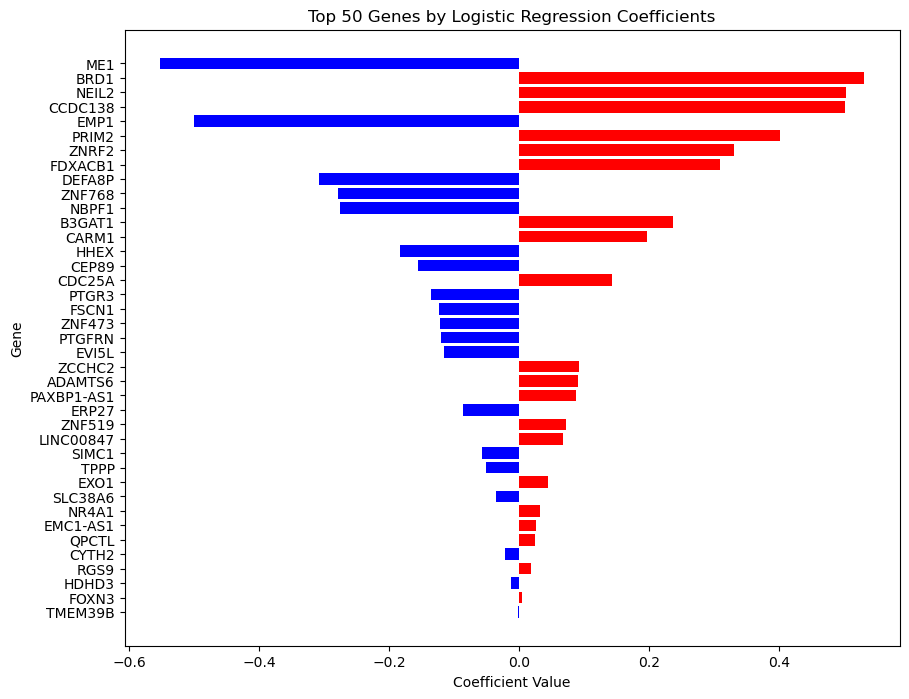

In [216]:
top_genes = genes.copy()
top_genes['abs_coefficient'] = top_genes['coefficient'].abs()
top_genes = top_genes.sort_values(by='abs_coefficient', ascending=False).head(50)
top_genes = top_genes[top_genes['coefficient'] != 0]
# Plot
plt.figure(figsize=(10, 8))
plt.barh(top_genes['gene'], top_genes['coefficient'], color=['blue' if x < 0 else 'red' for x in top_genes['coefficient']])
plt.xlabel('Coefficient Value')
plt.ylabel('Gene')
plt.title('Top 50 Genes by Logistic Regression Coefficients')
plt.gca().invert_yaxis()  # Highest coefficients at the top
explanation = """
In the chart below, genes with positive coefficients are shown in red, while those with negative coefficients are shown in blue. 
Positive coefficients indicate that an increase in the change of expression for these genes is associated with a higher likelihood 
of delirium (or the condition being modeled). Conversely, negative coefficients suggest that an increase in the change of expression 
for these genes is associated with a reduced likelihood of delirium. This helps identify which genes may play a role in increasing 
or decreasing the risk of delirium based on expression changes.
"""
print(explanation)